# Stage 1: Importing dependencies

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import csv
import nltk
import seaborn as sns
from matplotlib import pyplot as plt

from google.colab import drive

In [2]:
!pip install bert-for-tf2
!pip install sentencepiece
!pip install unidecode
!pip install clean-text 
!pip install cleantext
nltk.download('stopwords') 
!pip install wordcloud

     |████████████████████████████████| 41 kB 163 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=4138d1a53d1066f25d18d7a5d1531405e63c25b1b6e6fe4e2547213ed11b69e8
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=efcfb7bf33ad07be629851a3c89ba39d7672d1360a16026f7b123f72fba66b70
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=cb86ae6060d9de725d6f931208ffedfddeead7a9ca72d56123138b54f5d5490e
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params
     |████████████████████████████████| 1.2 MB 7.6 MB/s 
     |███████████████████████████

In [3]:
sns.set(style="darkgrid")

In [4]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

# Stage 2: Data preprocessing

## Loading files

Importing file from google drive

In [6]:
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/projects/BERT/dontpatronizeme_pcl.tsv'
    ,sep='\t'
    , skiprows=3
    , quoting=csv.QUOTE_NONE
    , engine="python"
    , encoding="latin1"
    , names=['doc_id', 'keyword', 'country_code', 'text', 'label'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10636 entries, 0 to 10635
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_id        10636 non-null  object
 1   keyword       10636 non-null  object
 2   country_code  10636 non-null  object
 3   text          10635 non-null  object
 4   label         10636 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 415.6+ KB


Drop any rows that contain nulls

In [9]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

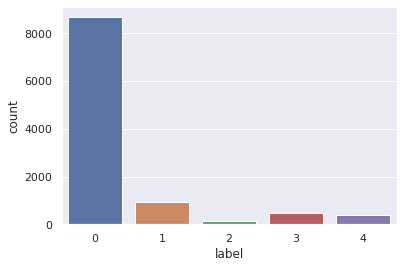

In [10]:
ax = sns.countplot(x="label", data=df)

Word Cloud

In [11]:
from wordcloud import WordCloud

def word_cloud(label,df):
    
    text = df[df['label'] == label]['text'].values 

    wordcloud = WordCloud().generate(str(text))

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

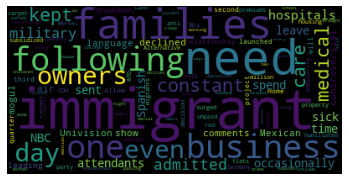

In [12]:
word_cloud(0,df)

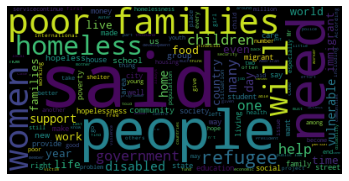

In [13]:
word_cloud(1,df)

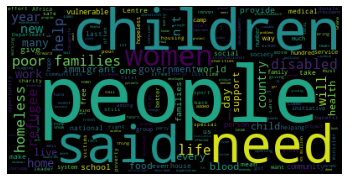

In [14]:
word_cloud(2,df)

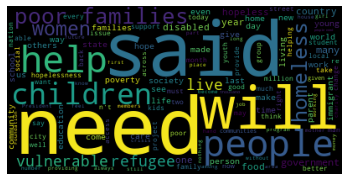

In [15]:
word_cloud(3,df)

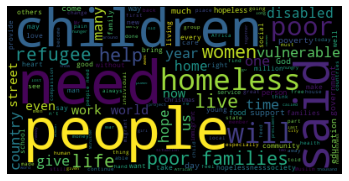

In [16]:
word_cloud(4,df)

All 0 and 1 label values mean that the sentence has been categorised as not having PCL. Otherwise the sentence does have PCL. There is a large bias here, therefore to help with the bias I will drop all rows where the label value is 1

In [17]:
df = df[df["text"].str.contains('@@') == False]
df = df[df.label != 1] # drop all where = 1 to help with imbalance

In [18]:
data = df.copy()

In [19]:
data.drop(["doc_id", "keyword", "country_code"],
          axis=1,
          inplace=True)

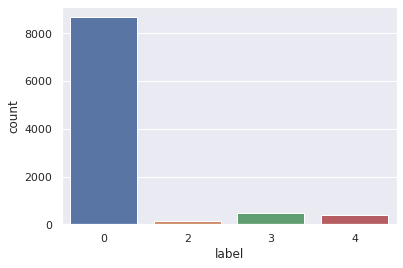

In [20]:
ax = sns.countplot(x="label", data=df)

Updating all labels of 2,3 & 4 to PCL detected (i.e. 1)

In [21]:
data.loc[data['label'] == 1, ['label']] = 0
data.loc[data['label'] == 2, ['label']] = 1
data.loc[data['label'] == 3, ['label']] = 1
data.loc[data['label'] == 4, ['label']] = 1

In [22]:
data['label'].value_counts()

0    8678
1    1002
Name: label, dtype: int64

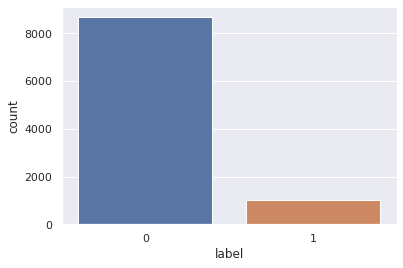

In [23]:
ax = sns.countplot(x="label", data=data)

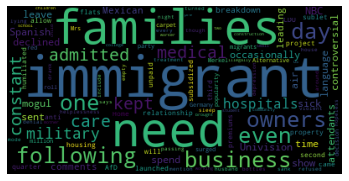

In [24]:
word_cloud(0,data)

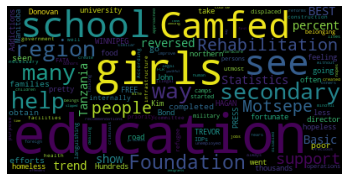

In [25]:
word_cloud(1,data)

Still a heavy bias in the data so I will remove 80% of the no PCL detected rows

In [26]:
df_bal = data.drop(data[data['label'] == 0].sample(frac=.8).index)

In [27]:
df_bal['label'].value_counts()

0    1736
1    1002
Name: label, dtype: int64

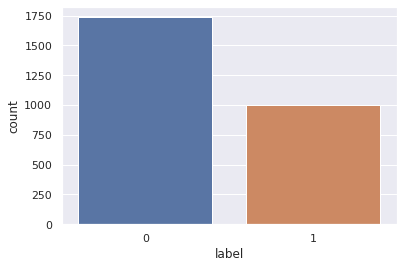

In [28]:
ax = sns.countplot(x="label", data=df_bal)

Since we do not have access to the validation data for this, I am going to separate and silo off 20% of data to be later used as validation.

In [29]:
val_data = df_bal.sample(frac = 0.2)
df_bal = df_bal.drop(val_data.index)

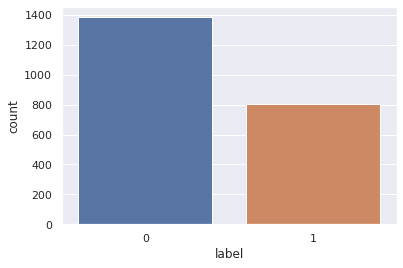

In [30]:
ax = sns.countplot(x="label", data=df_bal)

In [31]:
df_bal['label'].value_counts()

0    1385
1     805
Name: label, dtype: int64

In [32]:
val_data['label'].value_counts()

0    351
1    197
Name: label, dtype: int64

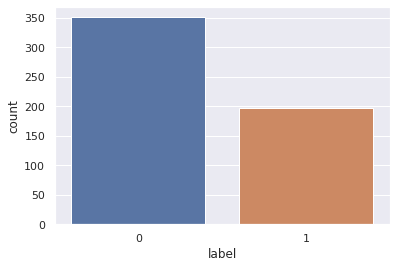

In [33]:
ax = sns.countplot(x="label", data=val_data)

## Preprocessing

### Cleaning

Function used to clean text

In [34]:
def clean_data(text):
    text = BeautifulSoup(text, "lxml").get_text()
    # Delete the @
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    # Delete URL links
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    # Just keep letters and important punctuation
    text = re.sub(r"[^a-zA-Z.!?']", ' ', text)
    ##
    text = re.sub(r"[^a-zA-Z\s]+", ' ', text)
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", ' ', text)
    # # Remove additional spaces
    text = re.sub(r" +", ' ', text)
    return text

In [35]:
data_clean = [clean_data(text) for text in data.text]

In [36]:
data_labels = data.label.values

In [37]:
word_df = pd.DataFrame(list(zip(data_clean, data_labels)),
              columns=['text','label'])


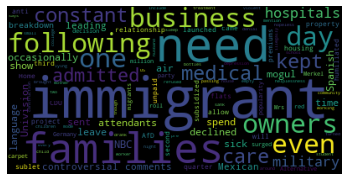

In [38]:
word_cloud(0,word_df)

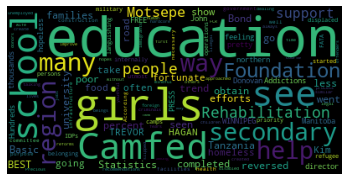

In [39]:
word_cloud(1,word_df)

### Tokenization

Creating a BERT layer to have access to meta data for the tokenizer (like vocab size).

In [40]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [41]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [42]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

### Dataset creation

Creating padded batches (so we pad sentences for each batch inpedendently), this way we add the minimum of padding tokens possible. For that, we sort sentences by length, apply padded_batches and then shuffle.

In [43]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [44]:
# A list is a type of iterator so it can be used as generator for a dataset
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [45]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

Spliting batches into 90% training and 10 test. The model will be tested further on text already silod away from the dataset at the end for final analysis.

In [46]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# Stage 3: Model building

In [47]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        ## The reason for having an option between 2 or other classes is because 
        ## this code could be reused to predict the 0-4 label classifications of PCL 
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    ## used for each time the model is called
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # (batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # (batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # (batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Stage 4: Training

In [48]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100 # number of features
FFN_UNITS = 256
NB_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [49]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [50]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [51]:
checkpoint_path = "./drive/MyDrive/projects/BERT/ckpt_bert_tok/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest Checkpoint restored!")

Latest Checkpoint restored!


In [52]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [53]:
Dcnn.fit(train_dataset,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

Epoch 1/5
    270/Unknown - 28s 63ms/step - loss: 2.9312e-09 - accuracy: 1.0000Checkpoint saved at ./drive/MyDrive/projects/BERT/ckpt_bert_tok/.
271/271 [==============================] - 28s 64ms/step - loss: 2.9296e-09 - accuracy: 1.0000
Epoch 2/5
271/271 [==============================] - 3s 10ms/step - loss: 2.0205e-09 - accuracy: 1.0000
Epoch 3/5
271/271 [==============================] - 3s 10ms/step - loss: 1.4879e-09 - accuracy: 1.0000
Epoch 4/5
271/271 [==============================] - 3s 10ms/step - loss: 1.3233e-09 - accuracy: 1.0000
Epoch 5/5
271/271 [==============================] - 3s 10ms/step - loss: 1.1078e-09 - accuracy: 1.0000


# Stage 5: Evaluation

In [54]:
# results = Dcnn.evaluate(test_dataset)
# print(results)

In [55]:
y_pred = Dcnn.predict(test_dataset)

In [56]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens, 0)

    output = Dcnn(inputs, training=False)

    pcl = math.floor(output*2)

    perc = np.array(output)[0][0]*100
    if pcl == 2:
        pcl = 1 

    if pcl == 0:

        print("PCL Predicted: No\nConfidence {:.2f} %".format(
            (100-perc))) # 0 -> 50 = No

    if pcl == 1:

        print("PCL Predicted: Yes\nConfidence {:.2f} %".format(
            perc)) # 50 -> 100 = Yes

    return pcl

In [ ]:
get_prediction("I need to go to the shop later to buy some eggs for breakfast tomorrow. I think I will go later because I need to refuel my car before driving into the city.")

In [68]:
get_prediction("The weather outside is not sunny today. I think I will stay indoors and watch TV.")

PCL Predicted: No
Confidence 97.37 %


0

In [70]:
get_prediction("Newcastle are now a very bad team that keeps losing due their the quality of the players.")

PCL Predicted: Yes
Confidence 67.91 %


1

In [69]:
get_prediction("Refugees are people who need more help than me.")

PCL Predicted: Yes
Confidence 99.96 %


1

In [ ]:
get_prediction("The spire was built in Dublin in the year 1980.")

In [60]:
get_prediction("I pity poor people. They should make more money.")

PCL Predicted: Yes
Confidence 99.99 %


1

In [ ]:
get_prediction("Is that what you are going to wear?")

PCL Predicted: Yes
Confidence 94.82 %


1

In [ ]:
get_prediction("You dress like a homeless person and smell worse.")

PCL Predicted: Yes
Confidence 99.98 %


1

In [ ]:
get_prediction("Newcastle are losing a lot of games.")

PCL Predicted: Yes
Confidence 86.00 %


1

In [ ]:
get_prediction("NCI is an excellent college.")

PCL Predicted: No
Confidence 94.52 %


0

In [ ]:
true_count = 0
false_count = 0
ar_y_val = []
ar_pred_val = []

# ar_false_positive = []
# ar_false_negative = []
# ar_true_positive = []
# ar_true_negative = []

for index, row in val_data.iterrows():
    text = row['text']
    true_val = row['label']
    try:
        pred_val = get_prediction(text)
    except:
        continue
    ar_y_val.append(true_val)
    ar_pred_val.append(pred_val)

# print(true_count)
# print(false_count)

PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: Yes
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL Predicted: No
Confidence 100.00 %
PCL 

In [ ]:
# false_positive = df.loc[(df['y_Predicted'] == 0) & (df['y_Actual'] == 1)]['y_Actual'].count()
# false_negative = df.loc[(df['y_Predicted'] == 1) & (df['y_Actual'] == 0)]['y_Actual'].count()
# true_positive = df.loc[(df['y_Predicted'] == 1) & (df['y_Actual'] == 1)]['y_Actual'].count()
# true_negative = df.loc[(df['y_Predicted'] == 0) & (df['y_Actual'] == 0)]['y_Actual'].count()
# precision = true_positive / (true_positive + false_positive)
# recall = true_positive / (true_positive + false_negative)
# f1_score = 2 * ((precision * recall) / (precision + recall))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

testy = ar_y_val
yhat_classes = ar_pred_val

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.972628
Precision: 0.968912
Recall: 0.954082
F1 score: 0.961440
Cohens kappa: 0.940225
[[346   6]
 [  9 187]]


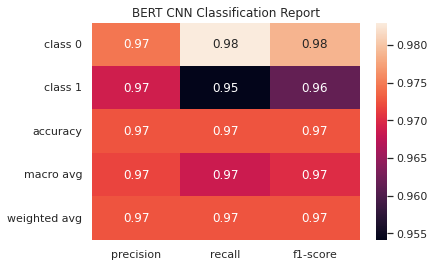

In [ ]:
from sklearn.metrics import classification_report
report= classification_report(testy, yhat_classes, target_names=['class 0', 'class 1'], output_dict=True)
ax = plt.axes()

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title('BERT CNN Classification Report')
plt.show()

Text(0.5, 1.0, 'BERT CNN PCL')

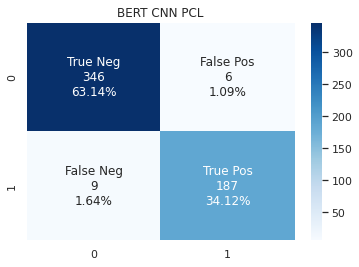

In [ ]:
names = ["True Neg","False Pos","False Neg","True Pos"]

counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]

percen = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in zip(names,counts,percen)]

x = plt.axes()

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(matrix,annot=labels, fmt='', cmap='Blues', ax=x)

x.set_title("BERT CNN PCL")

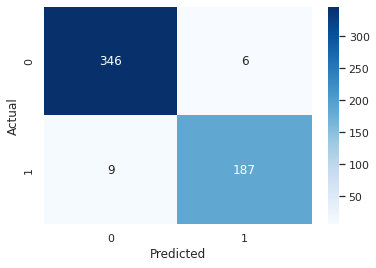

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'y_Actual':    ar_y_val,
        'y_Predicted': ar_pred_val
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

#sns.set(rc={'figure.figsize':(9,7)})
sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()